# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# azdias
print("Structure 'azdias': ")
azdias.shape

Structure 'azdias': 


(891221, 85)

**Notes**  
The given dataset at the beginning contains `891221` rows and `85`columns indicating no. of individuals and features, respectively.

In [4]:
azdias.head()
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [5]:
# feature infos:
print("\nStructure 'feature info': ", feat_info.shape)
print("\n",feat_info.head())
print("\nInformation level",feat_info["information_level"].unique())
print("\nData type", feat_info["type"].unique())


Structure 'feature info':  (85, 4)

               attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

Information level ['person' 'household' 'building' 'microcell_rr4' 'microcell_rr3' 'postcode'
 'region_rr1' 'macrocell_plz8' 'community']

Data type ['categorical' 'ordinal' 'numeric' 'mixed' 'interval']


In [6]:
# Show feature info by information level and by type
print(feat_info.groupby(by="information_level").size())
print("\n",feat_info.groupby(by="type").size())

information_level
building           7
community          3
household          7
macrocell_plz8     8
microcell_rr3      6
microcell_rr4      3
person            43
postcode           3
region_rr1         5
dtype: int64

 type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64


**Notes**  
The features are seperated by level of how they are related to the individual. Hence there are 43 features directly related to the person, whereas other features are on the household (7) or community (3) level. 

Moreover, the data features have different measurement scales. Of the 85 features, 49 are ordinally scaled, 21 categorically and the rest of the features are either interval, mixed or numerically scaled. It seems reasonable to have a look at the individually measurement scales later on and process them further.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Now do this for the rest and change every missing_code to nan

# Identify missing or unknown data values and convert them to NaNs.
for index in feat_info.index:
    feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
    for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
        try:
            feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
        except:
            continue
    azdias.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)

**Notes**  
I used a loop to identify how missing or unknown values are coded and changed them to nan. This took a lot of time to figure out...

In [8]:
# Check if this worked:
azdias.loc[1:10]

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,NaN,3.0,2,1.0,2,2,5,3,1,5,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
col_missings = azdias.isnull().sum()
sort_index = np.argsort(-col_missings)
col_missings_sort = col_missings.iloc[sort_index] # sorted
print("Missings per col: (many to none)\n", col_missings_sort)
print("\nNo of total missings: ", azdias.isnull().sum().sum())

Missings per col: (many to none)
 TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
PLZ8_BAUMAX              116515
PLZ8_GBZ                 116515
PLZ8_ANTG1               116515
PLZ8_ANTG2               116515
PLZ8_ANTG3               116515
PLZ8_ANTG4               116515
PLZ8_HHZ                 116515
VERS_TYP                 111196
HEALTH_TYP               111196
SHOPPER_TYP              111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
      

In [10]:
total_missings = azdias.isnull().sum().sum()
total_entries = azdias.shape[0]*azdias.shape[1]
print("Entries missing: {:.2f}%".format( (total_missings / total_entries) * 100) )

Entries missing: 11.05%


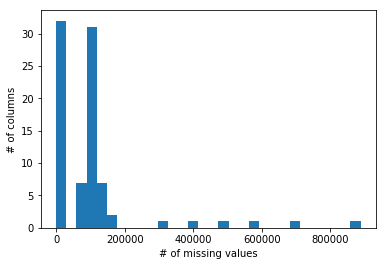

In [11]:
# Investigate patterns in the amount of missing data in each column.
#Use hist to identify columns with higher proportion of missings
#Histogram is suggested

plt.hist(col_missings, bins = 30)
plt.xlabel("# of missing values")
plt.ylabel("# of columns")

plt.show()

In [12]:
print("Cols given more than 159k missings:\n", col_missings_sort[col_missings_sort > 159000])
print("\nCols given more than 159k missings (in percent):\n", (col_missings_sort[col_missings_sort > 159000] / azdias.shape[0])*100)

Cols given more than 159k missings:
 TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
ALTER_HH        310267
dtype: int64

Cols given more than 159k missings (in percent):
 TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64


**Notes**:  
It seems as if there is a clear gap between columns with fewer than 159k missing values and 6 columns with more than 310k missing values per column. Again, there are no columns with no. of missing values between 159k (~17%) and 310k (~35%).

The first column with more than 159k missings (ascending order) is `ALTER_HH` with 310267 missing values or ~35%. The column with the most missing values is `TITEL_KZ` and has 889061 missing values (Recall from the shape that we have 891221 data entries). Hence, almost all data for this category are missing, except 2160. More than 99.7% of the data are missing in this column!

In [13]:
col_missings.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [14]:
no_missings = len(col_missings[col_missings == 0])
print("{} columns without missings!".format(no_missings))

24 columns without missings!


**Notes**  
The 85 columns have on average ~98,5k missing values, whereas the median is a little bit lower at ~93,1k missing values indicating that the distribution is right-skewed. 

In [15]:
# "outlier columns"
col_outlier = col_missings[col_missings > 159000]
col_outlier_names = col_missings[col_missings > 159000].index
print(col_outlier)
print("\nOutlier cols: \n", col_outlier_names)

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

Outlier cols: 
 Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


**Notes**  
Delete the following columns, which have been identified as outliers:  
- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- ALTER_HH
- KK_KUNDENTYP
- KBA05_BAUMAX

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(col_outlier_names, axis =1) # could also be done using inplace
print(azdias.shape)

(891221, 79)


**Comment**  
I want to note that it was not said to delete the outlier columns from the feat_info data as well and thus I did not remove them. Therefore, the number of cols in feat_info and azdias is different which probably should be considered throughout the analysis.

In [17]:
print("No. of total missings after deleting cols:",azdias.isnull().sum().sum())

No. of total missings after deleting cols: 5035304


In [18]:
col_missings2 = azdias.isnull().sum()
col_missings2.describe()

count        79.000000
mean      63738.025316
std       54253.866391
min           0.000000
25%           0.000000
50%       93148.000000
75%      108239.500000
max      158064.000000
dtype: float64

**Notes**  
- Before deleting the 6 columns we had `8373929` missing values
- After deleting we have `5035304` missing values left.
- Mean of missing values decreased to ~63,7k missing values.

In [19]:
print("Percent of missing or unknown values: ", (col_missings2.sum() / (azdias.shape[0] * azdias.shape[1]))*100)

Percent of missing or unknown values:  7.15176430049


#### Discussion 1.1.2: Assess Missing Data in Each Column
(Note that the discussion is built on the notes throughout the analysis)

The raw dataset contains 891,221 rows and 85 columns indicating no. of individuals and features, respectively.

Its features are categorized by level of collection and measurement scales (type). There are 43 features collected on the personal level, whereas other features are for example collected on the household (7) or community (3) level. 

Moreover, the data features have different measurement scales. Of the 85 features, 49 are ordinally scaled, 21 categorically and the rest of the features are either interval, mixed or numerically scaled. It seems reasonable to have a look at the individually measurement scales later on and process them further.

After changing the code for missings to nan it becomes visible that the dataset contains 8,373,929 missing or unknown values (11.05%). In the following analysis missing and unknown values are treated equally and the terms `missing` and `unknown` are interchangeably. 

Additionally, it can be seen that there is a clear gap between columns with fewer than 159k missing values and 6 columns with more than 310k missing values per column. Again, there are no columns with  missing values between 159k (~17%) and 310k (~35%).

The first column with more than 159k missings (ascending order) is `ALTER_HH` with 310,267 missing values or ~35%. The column with the most missing values is `TITEL_KZ` and has 889,061 missing values (Recall from the shape that we have 891,221 data entries). Hence, almost all data for this category are missing, except 2,160. More than 99.7% of the data are missing in this column!

The 85 columns have on average ~98,5k missing values, whereas the median is a little bit lower at ~93,1k missing values indicating that the distribution is right-skewed. In total, 11.05% of the entries are missing or unknown. Based on the aforementioned huge gap I decided to delete all columns with more than 159,000 missing values. 

Hence, I deleted the following columns, which I have identified as outliers:  
- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- ALTER_HH
- KK_KUNDENTYP
- KBA05_BAUMAX

Before deleting the 6 columns we had 8,373,929 missing values, whereas after deleting them  5,035,304 missing values are left. This decreased the mean of missing values to ~63,7k. In total 7.15% (-3.9) of the data are now missing or unknown. 

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?
row_missings = azdias.isnull().sum(axis=1)
row_missings.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [21]:
for i in range(50,100,5):
    print("0."+str(i), "Quantile", np.percentile(row_missings,i))

0.50 Quantile 0.0
0.55 Quantile 0.0
0.60 Quantile 0.0
0.65 Quantile 0.0
0.70 Quantile 1.0
0.75 Quantile 3.0
0.80 Quantile 5.0
0.85 Quantile 8.0
0.90 Quantile 34.0
0.95 Quantile 47.0


**Notes**  
After deleting the outlier columns we have on average 5.7 missing values per row. Moreover, the 0.5 quantile (median) as well as the 0.65 quantile is zero. Hence, 65% of the rows have zero missings. Additionally, even the 0.85 Quantile is only 8, which means that 85% of the rows have 8 or fewer missings.

In [22]:
print("Row missings fewer or equal 5:\n",len(row_missings[row_missings <= 5]))
print("Row missings more than 5:\n", len(row_missings[row_missings > 5]))

Row missings fewer or equal 5:
 719624
Row missings more than 5:
 171597


In [23]:
100 - ((len(row_missings[row_missings <= 5])/len(row_missings))*100)

19.25414683899953

**Notes**
We have 719,624 rows (80.75%) with fewer or equal to 5 missings and 171,597 rows (19.25%) have more than 5 missings. 

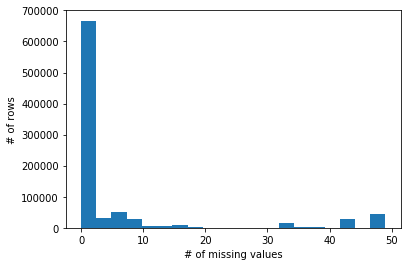

In [24]:
# Histogram
plt.hist(row_missings, bins = 20)
plt.xlabel("# of missing values")
plt.ylabel("# of rows")

plt.show()

**Notes**  
The histogram implies that there are many rows with zero or close to zero missing values. Moreover, (almost) no rows with 20 - 30 missing values before the number of rows with 30 or more missing values per rows are increasing again.

In [25]:
print("Row missings fewer or equal 20:\n",len(row_missings[row_missings <= 20]))
print("Row missings more than 20:\n", len(row_missings[row_missings > 20]))
print("Twenty or fewer missings values per row (percent):",(len(row_missings[row_missings <= 20]) / len(row_missings))*100)

Row missings fewer or equal 20:
 797426
Row missings more than 20:
 93795
Twenty or fewer missings values per row (percent): 89.47567438379481


**Notes**  
In addition it seems as there is a gap betwen 20 and 30 missing values per row as almost 90% of rows have fewer than 20 missing values. 

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# determine missing values to split data on

def subset_row_missings(missings_per_row=20):
    '''
    Function subsets azdias according to number of missings:
    Could also be done using negative indexing but this seems 
    clearer and more intuitive to me'''
    idx_be = row_missings.index[row_missings <= missings_per_row]
    idx_ab = row_missings.index[row_missings > missings_per_row] 
    sub1 = azdias.loc[idx_be]
    sub2 = azdias.loc[idx_ab]
    return sub1, sub2

sub1, sub2 = subset_row_missings(20)

In [27]:
# Check if this worked based on shape 
print("Shape of complete dataset : ", azdias.shape)
print("Rows with fewer or equal 20 missings: ", sub1.shape[0])
print("Rows with more than 20 missings: ", sub2.shape[0])

Shape of complete dataset :  (891221, 79)
Rows with fewer or equal 20 missings:  797426
Rows with more than 20 missings:  93795


In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# 1. Subset data based on no or few missing values (I have chosen this to be 10)
sub1, sub2 = subset_row_missings(20)
print("rows subset 1: ", sub1.shape[0])
print("rows subset 2: ", sub2.shape[0])

rows subset 1:  797426
rows subset 2:  93795


In [29]:
sub1.head()
sub2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
outlier_names2 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX']

In [31]:
# Choose (random) cols
import random

# Uncomment if you want 5 random cols
# five_cols = azdias.columns[np.random.randint(0, 79,5)]

five_cols = (["GREEN_AVANTGARDE", 
              "FINANZTYP", 
              "FINANZ_ANLEGER", 
              "SEMIO_PFLICHT", 
              "ZABEOTYP", 
              ])
five_cols

['GREEN_AVANTGARDE',
 'FINANZTYP',
 'FINANZ_ANLEGER',
 'SEMIO_PFLICHT',
 'ZABEOTYP']

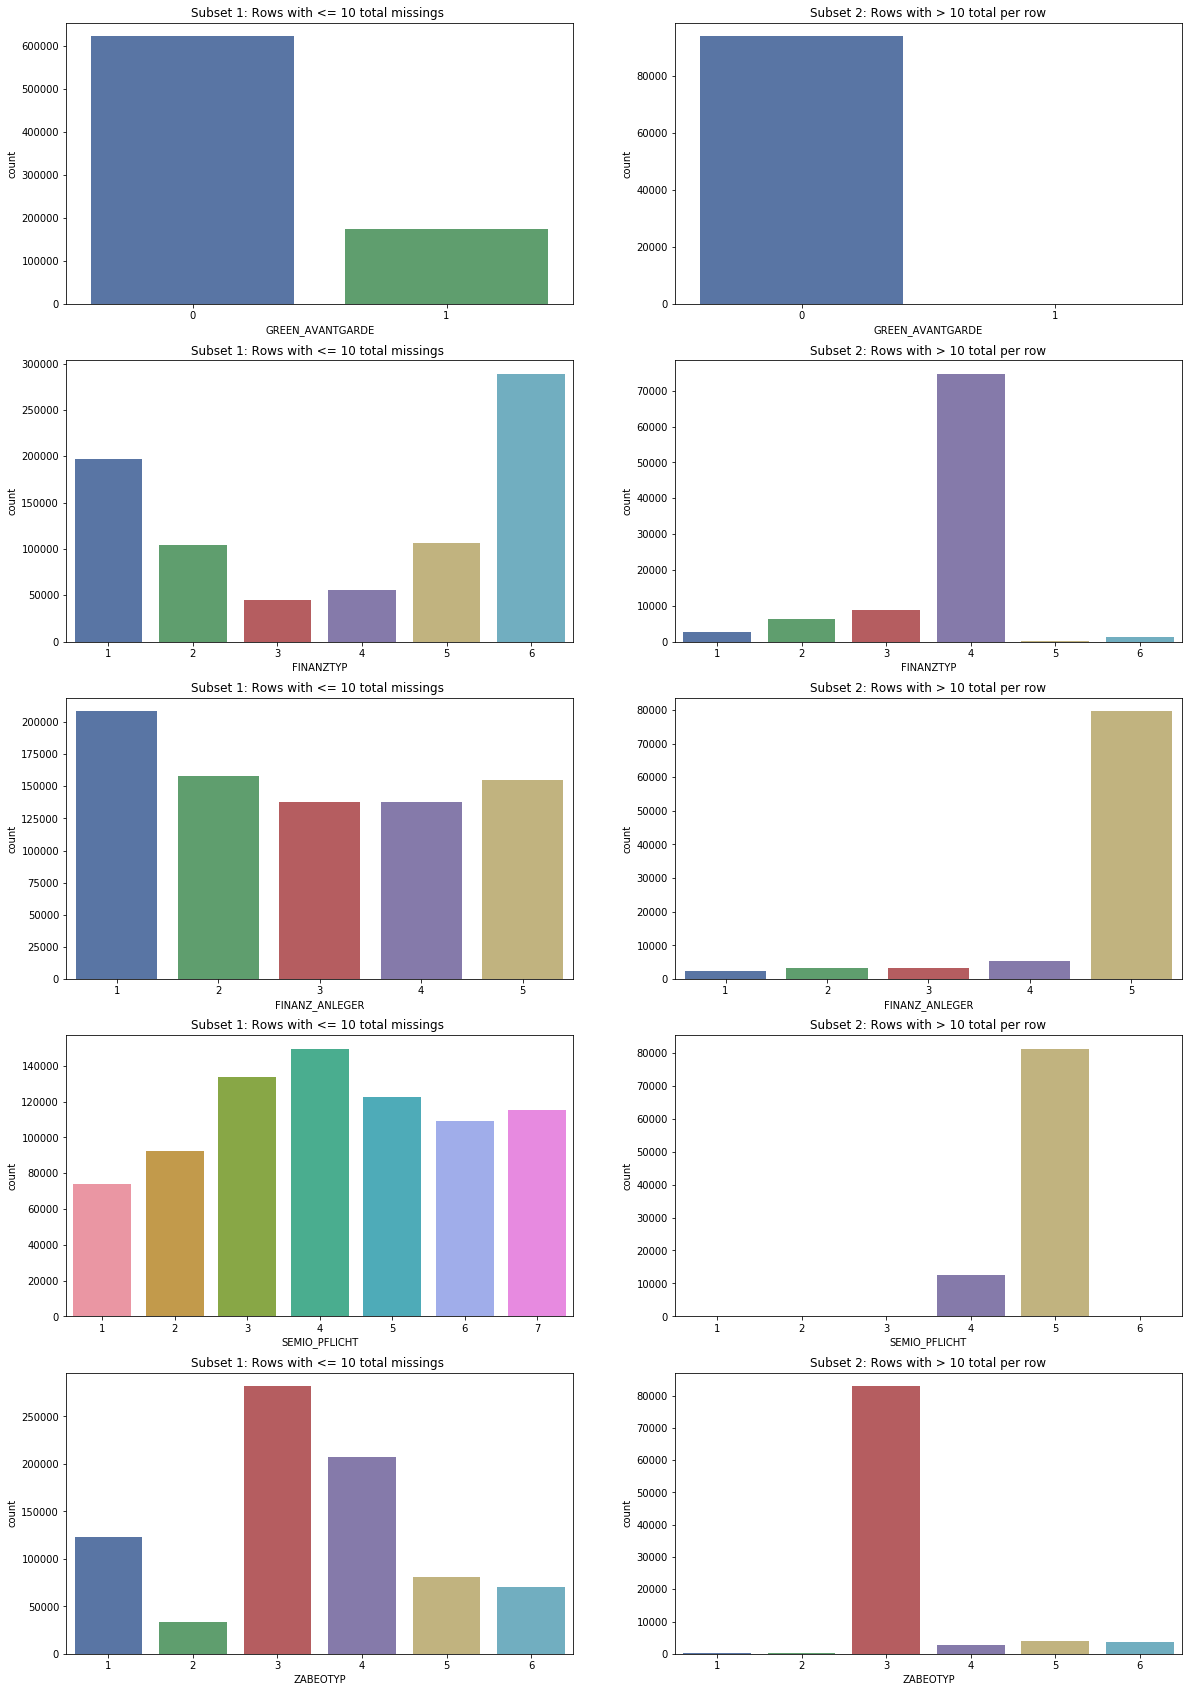

In [32]:
fig, axes = plt.subplots(nrows= 5, ncols = 2, figsize = (20,30))
n = 0

sns.set(style="darkgrid")

for column in five_cols:
    sns.countplot(sub1.loc[:, column], ax = axes[n,0])
    axes[n,0].set_title("Subset 1: Rows with <= 10 total missings ")
    sns.countplot(sub2.loc[:, column], ax = axes[n,1])
    axes[n,1].set_title("Subset 2: Rows with > 10 total per row")
    n+=1

**Notes**    
Function subset_row_missings divides the dataset into a subset 1 with fewer or equal to the determined values of missings per row and one subset which consists of the rows with more than the determined value of missings. 

The task is now to create a subset based on no or few missing values. I have determined this threshold to be five missing values per row. Afterwards I have plotted both subsets for five cols to see differences in distribution.


#### Discussion 1.1.3: Assess Missing Data in Each Row
After deleting the outlier columns we have on average 5.7 missing values per row. Moreover, the 0.5 quantile (median) as well as the 0.65 quantile is zero. Hence, 65% of the rows have zero missings. Additionally, even the 0.85 Quantile is only 8, which means that 85% of the rows have 8 or fewer missings.

We have 719,624 rows (80.75%) with fewer or equal to 5 missings and 171,597 rows (19.25%) have more than 5 missings. 

The histogram implies that there are many rows with zero or close to zero missing values. Moreover, (almost) no rows with 20 - 30 missing values before the number of rows with 30 or more missing values per rows are increasing again.

In addition it seems as there is a gap betwen 20 and 30 missing values per row as almost 90% of rows have fewer than 20 missing values.

Function subset_row_missings divides the dataset into a subset 1 with fewer or equal to the determined values of missings per row and one subset which consists of the rows with more than the determined value of missings. 

The task is now to create a subset based on no or few missing values. I have determined this threshold to be five missing values per row. Afterwards I have plotted both subsets for five cols to see differences in distribution.

Col. 1 ("GREEN AVANTGARDE"): Of those with fewer than 10 missing values per row roughly 180,000 are of type 1 in subset 1, whereas in subset 2 virtually nobody is of type 1

Col. 2 ("FINANZTYP"): Distribution between both subsets is pretty different here as well. Whereas the most common type in subset 1 is `6`, most of the individuals in subset 2 belong to group 4. 

Col. 3 ("FINANZ_ANLEGER"): Whereas the distribution of individuals in subset 1 (<= 10 missings) is roughly uniform for groups 2 to 5 and most individuals belong to group 1, most individuals in subset 2 belong exclusively to category 5. 

Col. 4 ("SEMIO_Pflicht"): Again we see a quite different distribution between both subsets. In subset 1 individuals are spread across many groups, in particular group 3-7. In stark contrast individuals of subset 2 belong only to group 5 and few to group 4.

Col. 5 ("ZABEOTYP"): For this feature we see that in both subsets the most common category is no.5. However, whereas individuals of subset 2 almost exclusively belong to this group, it is more heterogeneous for subset 1.   

In summary, I can conclude that the data with >10 missing values per row seem to be qualitatively very different from data with <= 10 missing values per row.

A major problem of missing data is the additional noise we get if we would include them in the analysis by imputation, taking averages, etc. Moreover, I have shown that those rows with <=  10 missing values are inherently different from the other rows. Hence, I have decided to continue the analysis using only the data of subset1 (`sub1`) from here. It may be interesting to compare both subsets in a later stage of the analysis to compare differences and the causal basis of why they are so different but this is beyond the scope of this project. 

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?
feat_info.groupby("type").count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


**Notes**  
Note that feat_info still includes the outlier columns since it was not specified to drop them as well and I decided to not drop them.

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

### Apply list comprehension to choose and change data
#in following steps

# Change to array
feat_info_categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values
feat_info_categorical = [x for x in feat_info_categorical if x in azdias.columns]

# Results in categorical features of the reduced dataset
print(len(feat_info_categorical))

18


**Notes**  
18 categorical features remain to be taken care of and which require "special handling". 

In [35]:
binary = [x for x in feat_info_categorical if azdias[x].nunique()==2]
azdias[binary][:5]

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
0,1,0,NaN,NaN,NaN
1,2,0,1.0,2.0,W
2,2,1,0.0,1.0,W
3,2,0,0.0,1.0,W
4,1,0,0.0,2.0,W


In [36]:
multilevel = [x for x in feat_info_categorical if azdias[x].nunique()>2]
azdias[multilevel][:5]

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,2.0,4,10.0,2.0,2.0,1.0,1.0,NaN,NaN,3,NaN,NaN,NaN
1,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5,8.0,8,8A
2,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5,1.0,4,4C
3,2.0,6,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3,1.0,2,2A
4,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4,1.0,6,6B


In [37]:
# Take a look at categorical data to decide on how to proceed
azdias[feat_info_categorical][:5]

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,1,2.0,4,10.0,0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4,4C
3,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2,2A
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6,6B


In [38]:
# And another look on how many categories we have per feature...
azdias[feat_info_categorical].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

**Notes**  
For the categorical data we see that most of them have fewer than 7 different categories which is fine to apply one-hot encoding (dummies). But there are three variables with 10, 11, and 12 categories respectively, which I will drop for various reasons as they result in too many dummies which may lead to computational performance issues later on. Moreover, for STATUS and FAMILIE there are close substitutes constituting of almost the same information in a broader coding.  

In addition, there is one variable that stoods out, namely "CAMEO_DEU_2015" which has 44 factors and encodings like "8A, 4C, 6B", etc. I decided to drop this variable and not construct 44 dummies for this variable.

In addition, the variable `OST_WEST_KZ` is decoded as "W" and "O" (in german "Osten" for "East") will take care of this as will and re-encode this to "W" as 0 and "O" to 1. 

In [39]:
multilevel

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [40]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Drop variables as stated above
col_remove = ["CAMEO_DEU_2015", "GFK_URLAUBERTYP", 
              "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]

for col in col_remove:
    multilevel.remove(col)
    sub1.drop(col, axis = 1, inplace=True)

sub1.shape

(797426, 75)

In [41]:
sub1["OST_WEST_KZ"] = sub1["OST_WEST_KZ"].map({"W": 0, "O": 1})
sub1[:5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [42]:
# Check if it worked. Ought to be two values
sub1["OST_WEST_KZ"][:10]
sub1["OST_WEST_KZ"].nunique()

2

In [43]:
# Last step is to re-encode the other categorical variables 
#using pd.get_dummies

for col in multilevel:
    df = sub1[col][sub1[col].notnull()]
    sub1 = sub1.join(pd.get_dummies(df, prefix=col))
    sub1.drop([col], axis = 1, inplace=True)

In [44]:
sub1.shape

(797426, 117)

**Notes**  
Shape is now 780,153 rows (because we dropped all rows with more than 10 missing values) and 150 features (after re-encoding and adding dummies) which seems plausible. 

#### Discussion 1.2.1: Re-Encode Categorical Features
Of 21 initial categorical variables we have 18 categorical features remain to be taken care of and which require "special handling".

For the categorical data we see that most of them have fewer than 7 different categories which is fine to apply one-hot encoding (dummies). Moreover, there are three variables with 10, 11, and 12 categories respectively. It is tempting to drop them but I decided to keep them and stick to as much of the dataset as possible. If computational power would be a limiting factor one might consider to drop them. Finally, there is one variable that stoods out, namely "CAMEO_DEU_2015" which has 44 factors and encodings like "8A, 4C, 6B", etc. I decided to drop this variable and not construct 44 dummies for this variable.

In addition, the variable `OST_WEST_KZ` is decoded as "W" and "O" (in german "Osten" for "East") will take care of this as will and re-encode this to "W" as 0 and "O" to 1. 

Shape is now 780,153 rows (because we dropped all rows with more than 10 missing values) and 150 features (after re-encoding and adding dummies) which seems plausible.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [45]:
# Subbing mixed feat_info
feat_info_mixed = feat_info[feat_info["type"] == "mixed"]
mixed_array = feat_info_mixed["attribute"].values
# List comprehension to get mixed cols and only select cols
#we wanted to keep
mixed = [x for x in mixed_array if x in sub1.columns]
mixed[:10]

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [46]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
sub1["PRAEGENDE_JUGENDJAHRE"][:10]

1     14.0
2     15.0
3      8.0
4      8.0
5      3.0
6     10.0
7      8.0
8     11.0
9     15.0
10     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [47]:
# We want to capture the two variables for mainstream and avantgarde
#Following info are taken from Data_disctionary.md
ms, av = [1,3,4,8,10,12,14], [2,4,6,7,9,11,13,15]

In [48]:
# Function to disentangle
def disentangler(x):
    if x in ms: 
        res = 1
    elif x in av:
        res = 0
    else:
        res = x
    return res

In [49]:
# Create new variable indicating whether mainstream=1 or avantgarde =0
sub1["PRAEGENDE_JUGENDJAHRE_MS"] = sub1["PRAEGENDE_JUGENDJAHRE"].apply(disentangler)

In [50]:
sub1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MS
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [51]:
# Create 2nd variable 
x, y = [x+1 for x in range(15)], [40,40,50,50,60,60,60,70,70,80,80,80,80,90,90]
dec = pd.Series(y, x)

# Show decade mapping
dec

1     40
2     40
3     50
4     50
5     60
6     60
7     60
8     70
9     70
10    80
11    80
12    80
13    80
14    90
15    90
dtype: int64

In [52]:
sub1["PRAEGENDE_JUGENDJAHRE_DEC"] = sub1["PRAEGENDE_JUGENDJAHRE"].map(dec)
sub1["PRAEGENDE_JUGENDJAHRE_DEC"][:10]

1     90.0
2     90.0
3     70.0
4     70.0
5     50.0
6     80.0
7     70.0
8     80.0
9     90.0
10    50.0
Name: PRAEGENDE_JUGENDJAHRE_DEC, dtype: float64

In [53]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
sub1["CAMEO_INTL_2015"][:10]

1     51
2     24
3     12
4     43
5     54
6     22
7     14
8     13
9     15
10    51
Name: CAMEO_INTL_2015, dtype: object

In [54]:
# Engineer first variable
sub1.loc[sub1['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_WEALTH'] = sub1.loc[sub1['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[0]))

In [55]:
sub1["CAMEO_INTL_2015_WEALTH"][:5]

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: CAMEO_INTL_2015_WEALTH, dtype: float64

In [56]:
# Engineer second variable
sub1.loc[sub1['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_LIFESTAGE'] = sub1.loc[sub1['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[1]))

In [57]:
sub1['CAMEO_INTL_2015_LIFESTAGE'][:5]

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: float64

In [58]:
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [59]:
# Drop all un-engineered mixed variables
sub1.drop(mixed, axis=1, inplace=True)

In [60]:
sub1[:5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MS,PRAEGENDE_JUGENDJAHRE_DEC,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,90.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,70.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,70.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,50.0,5.0,4.0


In [61]:
sub1.shape

(797426, 115)

#### Discussion 1.2.2: Engineer Mixed-Type Features
The first step was to look at the "mixed" features which consists of 6 features shown above.

After looking at the `PRAEGENDE_JUGENDJAHRE` and following the hints I saw in data_dictionary that one can disentangle (re-encode) the variable `PRAEGENDE_JUGENDJAHRE` into mainstream (ms) and avantgarde (av) based on leading to a new binary variable.

In addition, I have chosen to include a variable which indicates the respective decade. 

Next, after a look at `CAMEO_INTL_2015` and the respective data_dictionary one can engineer this variable into one for wealth and one for the respective lifestage which I decided after looking at the variable and the description in the data dictionary.

Note that all used variables should be dropped. In addition I have chosen to drop LP_LEBENSPHASE_FEIN as it consists of almost the same information as LP_LEBENSPHASE_GROB and has too many levels. I think one should delete at least one (possible multicollinearity) and decided for the more complicated one.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [62]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# -> DONE

In [63]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# -> DONE

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [64]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    for index in feat_info.index:
        feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
        for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
            try:
                feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
            except:
                continue
        df.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)        
    
    # Drop cols (outlier cols) + "GEBAUEDTYP" (issues with dummies)
    drop_col = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX', "GEBAEUDETYP"]
    df.drop(drop_col , axis=1, inplace=True)
    
    # Index for rows with missings of equal or fewer than 20
    row_missings = df.isnull().sum(axis=1)
    idx1 = row_missings.index[row_missings <= 20]
    idx2 = row_missings.index[row_missings > 20]
    
    categorical = feat_info[feat_info["type"] == "categorical"]["attribute"].values
    categorical = [x for x in categorical if x in df.columns]
    binary = [x for x in categorical if df[x].nunique()==2]
    multilevel = [x for x in categorical if df[x].nunique()>2]
    
    col_remove = ["CAMEO_DEU_2015", "GFK_URLAUBERTYP", 
              "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]

    for col in col_remove:
        multilevel.remove(col)
        df.drop(col, axis = 1, inplace=True)

    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].map({"W": 0, "O": 1})
    
    for col in multilevel:
        dat = df[col][df[col].notnull()]
        df = df.join(pd.get_dummies(dat, prefix=col))
        df.drop([col], axis=1, inplace=True)
    
    mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values
    mixed = [x for x in mixed if x in df.columns] 
        
    ms = [1,3,4,8,10,12,14]
    av = [2,4,6,7,9,11,13,15]
    df['PRAEGENDE_JUGENDJAHRE_MS'] = df['PRAEGENDE_JUGENDJAHRE'].apply(disentangler)
      
    x = [x+1 for x in range(15)]
    y = [40,40,50,50,60,60,60,70,70,80,80,80,80,90,90]
    dec = pd.Series(y, index = x)
    df['PRAEGENDE_JUGENDJAHRE_DEC'] = df['PRAEGENDE_JUGENDJAHRE'].map(dec)
    
    df.loc[df['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_WEALTH'] = df.loc[df['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[0]))
    df.loc[df['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_LIFESTAGE'] = df.loc[df['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[1]))

    df.drop(mixed, axis=1, inplace=True)
    
    clean_df = df.loc[idx1]
    dirty_df = df.loc[idx2]  
        
    # Return clean and dirty dataframe.
    return clean_df, dirty_df

**Notes**  
Due to problems with the variable "GEBAEUDETYP" I had to drop this variable in the function in addition to previously dropped categorical variables. It was differently dummy-encoded causing problems later on. Whereas the function worked fine on the azdias data applying the function to the customers data left out the dummy "GEBAUEDETYP_5.0"

In [65]:
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [66]:
# Reload and check if the function worked
import time
start = time.time()
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")
clean_azdias, dirty_azdias = clean_data(azdias)
end = time.time()
print(end - start)

151.84265160560608


In [67]:
# Load customers data to check if we have same numbers of cols, etc.
start = time.time()
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")
clean_customers, dirty_customers = clean_data(customers)
end = time.time()
print(end - start)

10.552395582199097


In [68]:
clean_azdias.shape

(797426, 108)

In [69]:
clean_customers.shape

(141640, 108)

In [70]:
# To keep previous notation as well as to simplify it
sub1 = clean_azdias
customers = clean_customers

### Hoooray, it worked!

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [71]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Initialize
imputer = Imputer()
sub1 = pd.DataFrame(imputer.fit_transform(sub1), columns = sub1.columns)

In [72]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
sub1 = pd.DataFrame(scaler.fit_transform(sub1), columns=sub1.columns)

### Discussion 2.1: Apply Feature Scaling
As hinted In the introducing text I have loaded and applied the Imputer class as well as the StandardScaler to scale the feature to mean 0 and standard deviaion 1.

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [73]:
# Apply PCA to the data ->Initialize and fit
pca = PCA()
sub1_pca = pca.fit_transform(sub1)

In [74]:
np.cumsum(pca.explained_variance_ratio_)[:50]

array([ 0.12151871,  0.21882256,  0.28027692,  0.31648147,  0.34375323,
        0.36555191,  0.38541812,  0.40510349,  0.42336413,  0.44102372,
        0.45800588,  0.47376023,  0.4885777 ,  0.50286147,  0.51631735,
        0.52936753,  0.54211465,  0.55430394,  0.56640831,  0.57847996,
        0.59005957,  0.60141934,  0.61259071,  0.62361846,  0.63456035,
        0.64539643,  0.65592829,  0.66640222,  0.676737  ,  0.68690422,
        0.69703054,  0.70689993,  0.71674038,  0.72647349,  0.73608417,
        0.74555012,  0.75497633,  0.76419137,  0.77318761,  0.78213186,
        0.79100514,  0.79958539,  0.80812077,  0.81642414,  0.8243143 ,
        0.8320925 ,  0.83963406,  0.84705163,  0.85414269,  0.86100243])

**Notes**  
From above we see that we need around 43 principal components to get to a cum. variance of more than 80%.

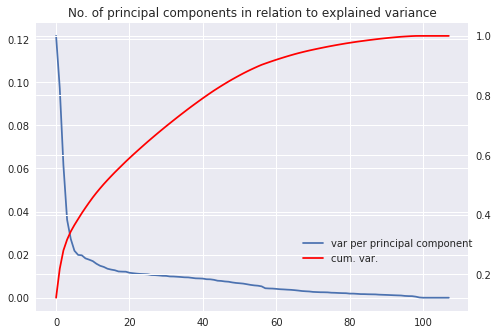

In [75]:
# Investigate the variance accounted for by each principal component.
# Use matplotlibs plot-function
fig = plt.figure()
ax = fig.add_axes([0,0,1,1],True)
ax.set_title("No. of principal components in relation to explained variance")
ax2 = ax.twinx()
ax.plot(pca.explained_variance_ratio_, label='var per principal component',)
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='cum. var.',color = 'red');
fig.legend(loc=(0.6,0.2));

**Notes**  
Fewer than 20 principal components are required to get a cum. explained variance of 50%. Moreover, with around 40 principal components, 80% of variance can be explained.

In [76]:
# Re-apply PCA to the data while selecting for number of components to retain.
n = 43
pca = PCA(n_components = n, random_state=42)
sub1_pca = pca.fit_transform(sub1)
pca_expl = pca.explained_variance_ratio_.sum()
print("Explained variance using {} components is: {:.2f}%".format(n,pca_expl*100))

Explained variance using 43 components is: 80.72%


### Discussion 2.2: Perform Dimensionality Reduction
In this section I applied PCA on the cleaned data. First, I had a look at how many
principal components were required to achieve 80% which was 43.

Afterwards, I plotted a curve to see the behaviour of added explained variance vs cumulative explained variance.
Around 40-45 principal components are required to explain 80% of variance, whereas the first 20 principal components already explain around 60% of the variacnce.

Lastly, I re-applied PCA determining how many principal components I want to use which leads to an cumulative explained variance of 80.72%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [77]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_fun(data):
    feat = pd.Series(data.columns, range(len(data.columns)))
    comp = {}
    for i in range(pca.components_.shape[0]):
        comp[i] = [(feat[a],b) for a,b in sorted(enumerate(pca.components_[i]),key=lambda x:x[1],reverse=True)]
    return pd.DataFrame(comp)

comp = pca_fun(sub1)

### First principal component

In [78]:
# Map weights for the first principal components to corresponding feature names
#and then print the linked values, sorted by weight.
comp[:6][0]

0        (LP_STATUS_GROB_1.0, 0.203256824049)
1                (PLZ8_ANTG3, 0.194085394489)
2    (CAMEO_INTL_2015_WEALTH, 0.189239983742)
3        (HH_EINKOMMEN_SCORE, 0.188923475617)
4                (PLZ8_ANTG4, 0.187426680109)
5               (ORTSGR_KLS9, 0.167996265817)
Name: 0, dtype: object

In [79]:
comp[-6:][0]

102          (KONSUMNAEHE, -0.144298026929)
103            (KBA05_GBZ, -0.189577837962)
104           (PLZ8_ANTG1, -0.193547552272)
105          (KBA05_ANTG1, -0.199190505938)
106    (FINANZ_MINIMALIST, -0.212098221954)
107           (MOBI_REGIO, -0.213056148557)
Name: 0, dtype: object

### Second principal component

In [80]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp[:6][1]

0    (ALTERSKATEGORIE_GROB, 0.225932316382)
1         (FINANZ_VORSORGER, 0.21164474877)
2              (ZABEOTYP_3, 0.205139834848)
3               (SEMIO_ERL, 0.188273997142)
4              (SEMIO_LUST, 0.160218688418)
5          (RETOURTYP_BK_S, 0.153378147131)
Name: 1, dtype: object

In [81]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp[:-6][1]

0          (ALTERSKATEGORIE_GROB, 0.225932316382)
1               (FINANZ_VORSORGER, 0.21164474877)
2                    (ZABEOTYP_3, 0.205139834848)
3                     (SEMIO_ERL, 0.188273997142)
4                    (SEMIO_LUST, 0.160218688418)
5                (RETOURTYP_BK_S, 0.153378147131)
6                (W_KEIT_KIND_HH, 0.126847944146)
7              (FINANZ_HAUSBAUER, 0.119069108942)
8      (PRAEGENDE_JUGENDJAHRE_MS, 0.114087713934)
9              (CJT_GESAMTTYP_2.0, 0.10557786428)
10                  (PLZ8_ANTG3, 0.0938741854504)
11                 (FINANZTYP_5, 0.0938019081879)
12                  (PLZ8_ANTG4, 0.0894557083137)
13                   (SEMIO_KRIT, 0.087430827366)
14      (CAMEO_INTL_2015_WEALTH, 0.0873451190011)
15                    (EWDICHTE, 0.0855242805031)
16                 (ORTSGR_KLS9, 0.0848665562422)
17                 (FINANZTYP_2, 0.0837518510844)
18                   (SEMIO_KAEM, 0.080010254012)
19             (SHOPPER_TYP_3.0, 0.0731809875957)


### Third principal component

In [82]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp[:6][2]

0           (SEMIO_VERT, 0.326736306237)
1            (SEMIO_FAM, 0.258069162458)
2            (SEMIO_SOZ, 0.257711992069)
3           (SEMIO_KULT, 0.246905701408)
4          (FINANZTYP_5, 0.136847325686)
5    (FINANZ_MINIMALIST, 0.133904136645)
Name: 2, dtype: object

In [83]:
comp[-6:][2]

102     (SEMIO_RAT, -0.177946904622)
103     (SEMIO_ERL, -0.196732905779)
104    (SEMIO_KRIT, -0.270696878457)
105     (SEMIO_DOM, -0.299995472489)
106    (SEMIO_KAEM, -0.326522802506)
107     (ANREDE_KZ, -0.354170847399)
Name: 2, dtype: object

### Discussion 2.3: Interpret Principal Components
Important variables **first principal component:**  
High correlation and thus of high importance in explaining the variation of this component are the status of the people, income, as well as living conditions (especially living in regions where houses with a lot of famlies are prevalent. Moreover, wealth is of high importance as well as size of community. 

Important variables for **second principal component:**  
The dimension of this principal component is determined by age and financial literacy. This component further describes whether people are saving money, are financial literate as well as variables on personal attitudes, especially whether people are dutiful, traditional and/ or religious.

Important variables for the **third principal component:**  
In particular variables concerning personality typology are in play here. Positively effect on the component have whether someone is dreamful, family-, socially-, or cultureal-minded. Low financial interest is positively correlated. Negatively correlated with this component are people, described as rational, event-oriented, critical-minded or combative. Moreover, gender variable is negatively associated with this component.  

It can be noted that in PCA the factor loading is the correlation of the variable on the respective PC. Therefore negative and positive values are important. The higher the number the further away from the midpoint and, thus,  the more important they are for the principal component.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [84]:
# Because KMeans takes so long I will use MiniBatchKMeans for determining
#the optimal no. of clusters
cluster_nums = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
distances = []
score = []

# Over a number of different cluster counts...
for c in cluster_nums:  
    # run k-means clustering on the data
    # using MiniBatchKMeans() due to performance issues
    
    kmeans = MiniBatchKMeans(c)
    preds = kmeans.fit_predict(sub1_pca)
    
    # compute average within-cluster distances.
    pred_centroids = kmeans.cluster_centers_
    centers = pred_centroids[preds]
    distance = np.sqrt(((sub1_pca - centers) ** 2).sum(axis=1)).mean()
    distances.append(distance)
    
    # Score 
    sc = kmeans.score(sub1_pca)
    score.append(sc)
    
    print("Evaluation of {} clusters | Distance:{:.4f} | Score: {:.4f}".format(c, distance, sc))

Evaluation of 1 clusters | Distance:9.2303 | Score: -69514246.6735
Evaluation of 2 clusters | Distance:8.7117 | Score: -62194346.6203
Evaluation of 3 clusters | Distance:8.3742 | Score: -57562676.5145
Evaluation of 4 clusters | Distance:8.2580 | Score: -55978104.9732
Evaluation of 5 clusters | Distance:8.0572 | Score: -53336064.2676
Evaluation of 6 clusters | Distance:8.0580 | Score: -53328357.0256
Evaluation of 7 clusters | Distance:7.9912 | Score: -52527076.4291
Evaluation of 8 clusters | Distance:7.8504 | Score: -50739538.9272
Evaluation of 9 clusters | Distance:7.7157 | Score: -49092013.6477
Evaluation of 10 clusters | Distance:7.7162 | Score: -49055978.3639
Evaluation of 11 clusters | Distance:7.6586 | Score: -48410671.9769
Evaluation of 12 clusters | Distance:7.5733 | Score: -47360608.1979
Evaluation of 13 clusters | Distance:7.5951 | Score: -47643664.6044
Evaluation of 14 clusters | Distance:7.5361 | Score: -46555800.4157
Evaluation of 15 clusters | Distance:7.4781 | Score: -460

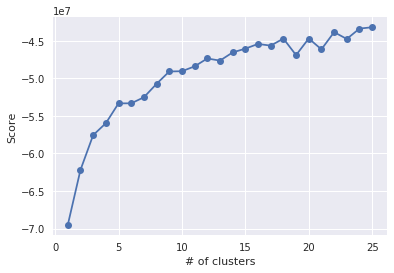

In [85]:
plt.plot(cluster_nums, score, '-o');
plt.ylabel("Score")
plt.xlabel("# of clusters");

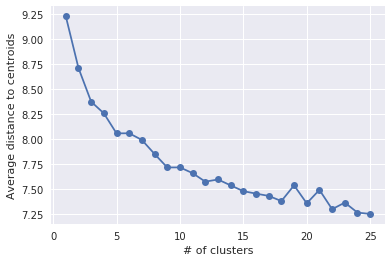

In [86]:
plt.plot(cluster_nums, distances, '-o');
plt.ylabel("Average distance to centroids")
plt.xlabel("# of clusters");

In [87]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(11, random_state=42)
clusters_pop = kmeans.fit_predict(sub1_pca)

### Discussion 3.1: Apply Clustering to General Population
Because of performance issues with KMeans() I choose MiniBatchKmeans() first to determine the number of clusters. In order to do this I plotted the score as well as the avearge distance to centroids. After a rapid increase (plot1), respectively decrease (plot2) after 7 clusters it seems as for both plots the change seems to be rather small. In particular after 10-15 clusters there is not much change here. Hence, following the elbow method, one should choose between 10-15 clusters. As there seems to be a small uptick after 11 clusters I choose to take 11 clusters in the following Analysis. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

#### Do not change the objects or fit in the following:

In [88]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Load in the customer demographics data, if not done before
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter =";")
customers, dirty_customers = clean_data(customers)

# Impute
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

# Scale
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

# PCA
customers_pca = pca.transform(customers)

# KMeans
clusters_customers = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [89]:
dirty_azdias_array = np.full((dirty_azdias.shape[0],),-1)
clusters_full_azdias = np.concatenate([clusters_pop, dirty_azdias_array])

dirty_customers_array = np.full((dirty_customers.shape[0],),-1)
clusters_full_customers = np.concatenate([clusters_customers, dirty_customers_array])

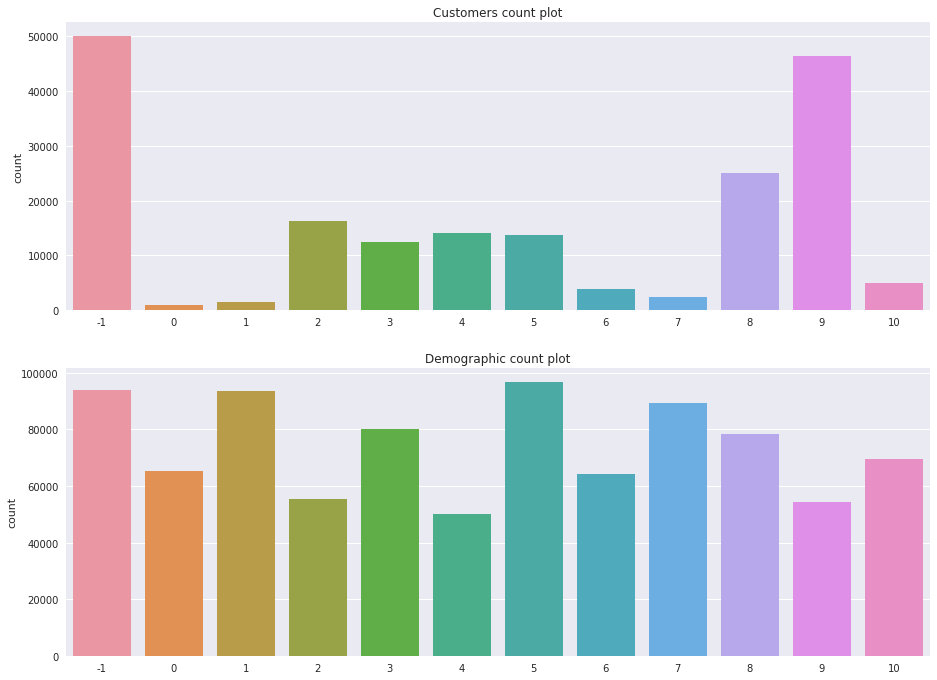

In [90]:
# Visualization
fig = plt.figure()
ax1=fig.add_axes([0,1.2,2,1], title='Demographic count plot')
ax2=fig.add_axes([0,2.4,2,1], title='Customers count plot')
sns.set(style="darkgrid")
sns.countplot(clusters_full_azdias, label='demographic', ax=ax1)
sns.countplot(clusters_full_customers, label='customer', ax=ax2)
ax.legend();

**Notes**  
The above visualization give the imporession that customers of the company are inherently differnt from the population. 

However, the plot is a little bit misleading as it is in absolute units. For now, underrepresented customers seem to be in clusters 0, 1, 5, 6,7 and 10. Overrepresented as customers of the company seem to be individuals of cluster 9.

In [91]:
total_cust = len(clusters_full_customers)

cluster, counts = np.unique(clusters_full_customers, return_counts = True)
dict_clusters_full_customers = dict(zip(cluster, counts))

cluster_prop_cust = {}

for cluster, num in dict_clusters_full_customers.items():
    print("Cluster {}:".format(cluster), round((num / total_cust)*100,2),"%")
    cluster_prop_cust[cluster] = num/total_cust

Cluster -1: 26.1 %
Cluster 0: 0.53 %
Cluster 1: 0.78 %
Cluster 2: 8.52 %
Cluster 3: 6.46 %
Cluster 4: 7.37 %
Cluster 5: 7.18 %
Cluster 6: 2.0 %
Cluster 7: 1.3 %
Cluster 8: 13.07 %
Cluster 9: 24.16 %
Cluster 10: 2.54 %


In [92]:
total_pop = len(clusters_full_azdias)

cluster, counts2 = np.unique(clusters_full_azdias, return_counts = True)
dict_clusters_full_azdias = dict(zip(cluster, counts2))

cluster_prop_pop = {}

for cluster, num in dict_clusters_full_azdias.items():
    print("Cluster {}:".format(cluster), round((num / total_pop)*100,2),"%")
    cluster_prop_pop[cluster] = num/total_pop

Cluster -1: 10.52 %
Cluster 0: 7.31 %
Cluster 1: 10.51 %
Cluster 2: 6.22 %
Cluster 3: 8.99 %
Cluster 4: 5.63 %
Cluster 5: 10.87 %
Cluster 6: 7.22 %
Cluster 7: 10.04 %
Cluster 8: 8.79 %
Cluster 9: 6.09 %
Cluster 10: 7.8 %


In [93]:
cluster_prop_diff = {}

for i in range(-1,11):
    diff = (cluster_prop_cust[i] - cluster_prop_pop[i])
    cluster_prop_diff[i] = diff*100

cluster_prop_diff

{-1: 15.57088862627598,
 0: -6.7797482722214291,
 1: -9.7353121002422576,
 2: 2.2996472107777515,
 3: -2.5293577483058076,
 4: 1.7361897048887922,
 5: -3.6915236662671118,
 6: -5.2199978032153265,
 7: -8.7374164536991845,
 8: 4.2762762805044972,
 9: 18.073712480279948,
 10: -5.2633582587758534}

**Notes:**  
Overrepresented clusters (customers over population) are: 
- 9: +18.07
- -1: +15.57
- 8: +4.28%

Underrepresented clusters:
- 1: -9.74%
- 7: -8.74%
- 0: -6.8%

In a next step I will have a look at cluster 9 and 1 to see what the characteristics of those people are that are overrepresented (9) and underrepresented (1).

In [94]:
cluster = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), columns=sub1.columns)
cluster

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MS,PRAEGENDE_JUGENDJAHRE_DEC,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,1.866835,0.976900,1.746704,4.534506,1.924207,3.709440,3.953400,3.711475,0.101735,2.327463,...,0.023233,0.054054,0.116617,0.132143,0.308003,0.327861,0.865175,87.799178,4.366607,2.019686
1,1.786907,1.995758,1.107904,4.346833,2.250067,4.190556,3.778276,4.202132,0.028595,2.197702,...,0.014414,0.057275,0.122491,0.142240,0.307834,0.307501,1.044349,85.585739,4.343405,2.079002
2,3.364003,1.938942,4.210196,1.708311,4.088632,2.190415,2.202432,2.234867,0.910870,2.141199,...,0.178175,0.070038,0.087432,0.030157,0.028695,0.013819,0.069898,66.857522,1.975421,3.653259
3,3.553059,1.925108,3.740091,1.586169,4.339228,2.620748,1.782636,3.018848,0.035555,2.027499,...,0.247121,0.089407,0.151212,0.076939,0.057547,0.025211,2.127535,63.638717,2.623474,3.353658
4,3.777925,1.035557,3.459417,1.358651,4.770983,1.145587,1.454756,4.102556,0.092530,1.728056,...,0.035278,0.056235,0.199479,0.136603,0.317934,0.190390,2.266343,57.678319,4.171747,2.706380
5,3.588712,1.958512,2.558509,1.882442,4.294826,2.215018,1.689267,4.301032,0.071896,2.047369,...,0.037076,0.059073,0.166576,0.146677,0.330854,0.205747,1.835530,63.086433,4.217935,2.656257
6,2.007339,0.983926,3.379245,3.925566,2.120843,3.749024,4.110871,1.819064,0.335106,2.218866,...,0.245875,0.078891,0.123066,0.063414,0.042503,0.003046,0.533574,86.662790,2.309570,3.272849
7,1.933806,1.969997,2.350830,3.932955,2.247277,4.380774,3.983215,2.767504,0.197098,2.243870,...,0.237911,0.085649,0.135758,0.070983,0.040593,0.021753,0.801394,86.281282,2.436447,3.221538
8,3.229246,1.118399,4.564899,1.667131,4.278054,2.207514,1.770948,2.153373,0.027064,2.345241,...,0.234852,0.080546,0.125241,0.071190,0.044993,0.026471,2.117988,65.792565,2.467195,3.281071
9,3.299215,1.054642,4.793719,1.628614,4.315473,1.470372,2.088865,1.942068,0.959398,2.018304,...,0.165548,0.065012,0.104967,0.046330,0.023371,0.014122,0.101531,65.287012,2.028539,3.612382


**Notes:**   

#### Cluster 9: Overrepresented
- Age: Over 46 and below 60
- Gender (1.05): Rather male 
- Financially heterogenous as people in this cluster seem to save money without actively preparing for old-age and having low financial interest
- not socially-minded, 
- religious

#### Cluster 1: Underrepresented
- Age (1.79): Under 30 
- Gender (1.99): Predominantly female
- Low financial interest, no money-saver
- socially-minded, family-minded, not religious

### Discussion 3.3: Compare Customer Data to Demographics Data

### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?
People in cluster 9 are overrepresented as customers in comparison to the total population. A typical individual in this cluster is between 46 and 60 and male. This individual is financially heterogenous as it saves money but does not actively prepare for old-age, is not socially minded but religious. 


### What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?
The group of customers in cluster 1 are the most underrpresented part in comparison to the population. People in this cluster are typically under 30 and female. Moreover, they have low financial interest and are no money-saver. These individuals are not regligious, socially- and family-minded.

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [95]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Identify_Customer_Segments.ipynb to html',
 '[NbConvertApp] Writing 709712 bytes to Identify_Customer_Segments.html']